# Predicting company acquisition

### Kaggle crunchbase challenge

Link: https://www.kaggle.com/arindam235/startup-investments-crunchbase

--- 

We have a dataset with thousands of companies across the world and across a range of sectors.

We will be trying to predict whether companies closed, were acquired or whether they are still running.

Key challenges:
- Classes are severely imbalanced
- Features needs significant engineering

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [125]:
# Basics
import pandas as pd
import numpy as np
import re

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Feature work
from sklearn.feature_extraction.text import CountVectorizer

# PreProcessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#Scoring
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

# EDA

In [3]:
df = pd.read_csv('investments_VC.csv', encoding = 'latin1')

In [4]:
df.shape

(54294, 39)

In [5]:
print(list(df.columns))

['permalink', 'name', 'homepage_url', 'category_list', ' market ', ' funding_total_usd ', 'status', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'founded_at', 'founded_month', 'founded_quarter', 'founded_year', 'first_funding_at', 'last_funding_at', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H']


In [6]:
df.duplicated().sum()

4855

In [7]:
df = df.drop_duplicates()

In [8]:
# Remove unwanted periods
df.columns = [i.strip() for i in df.columns]

In [9]:
df.iloc[:5,:10]

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas


In [10]:
df['funding_total_usd'] = df['funding_total_usd']\
        .apply(lambda x: ''.join(str(x).split(',')))\
        .apply(lambda x: re.sub('[^0-9]','', x))

In [11]:
df['funding_total_usd'].replace('', np.nan, inplace=True)

In [12]:
df['funding_total_usd'] = df['funding_total_usd'].astype(float)

In [13]:
df['funding_total_usd'].dropna().sort_values().tail()

15315    3.500000e+09
7977     5.162513e+09
8664     5.700000e+09
36911    5.800000e+09
45815    3.007950e+10
Name: funding_total_usd, dtype: float64

In [14]:
df.market.value_counts().head()

 Software          4620
 Biotechnology     3688
 Mobile            1983
 E-Commerce        1805
 Curated Web       1655
Name: market, dtype: int64

In [15]:
df.country_code.value_counts().head()

USA    28793
GBR     2642
CAN     1405
CHN     1239
DEU      968
Name: country_code, dtype: int64

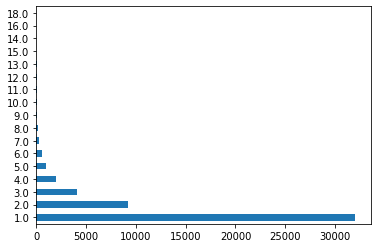

In [16]:
df.funding_rounds.value_counts().plot(kind = 'barh');

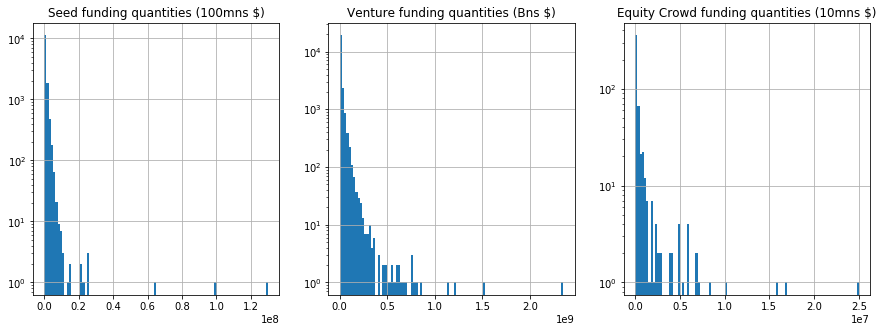

In [17]:
fig, ax = plt.subplots(ncols = 3, figsize = (15,5))
df[df['seed']>0].seed.hist(bins = 100, ax = ax[0]);
df[df['venture']>0].venture.hist(bins = 100, ax = ax[1]);
df[df['equity_crowdfunding']>0].equity_crowdfunding.hist(bins = 100, ax = ax[2]);
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].set_title("Seed funding quantities (100mns $)")
ax[1].set_title("Venture funding quantities (Bns $)")
ax[2].set_title("Equity Crowd funding quantities (10mns $)")
plt.show()

Lets check that all the rounds of funding are equal to the funding quantities.

In [18]:
df.iloc[40:60,18:40].T

,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
seed,0.0,0.0,0.0,250000.0,69000.0,500000.0,0.0,378812.0,130636.0,0.0,0.0,0.0,0.0,700000.0,0.0,500000.0,0.0,2200000.0,200000.0,0.0
venture,0.0,0.0,0.0,0.0,0.0,150267.0,0.0,0.0,0.0,0.0,0.0,63450000.0,0.0,0.0,5500000.0,0.0,6204822.0,0.0,0.0,199957.0
equity_crowdfunding,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
undisclosed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
convertible_note,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
debt_financing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
angel,0.0,0.0,0.0,0.0,500000.0,0.0,0.0,0.0,0.0,619494.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200000.0,0.0,0.0
grant,0.0,0.0,0.0,20000.0,225000.0,0.0,0.0,0.0,0.0,0.0,0.0,3000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
private_equity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
post_ipo_equity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
tot_round = df.iloc[:,31:40].T.sum()

In [20]:
tot_funds = df.iloc[:,18:31].T.sum()

In [21]:
print('There are {} instances of larger sums of round funding than other financing data'.format((tot_round>tot_funds).sum()))

There are 0 instances of larger sums of round funding than other financing data


It seems that some funding round info is missing. Lets treat it as a categorical binary variable instead.

In [22]:
df.iloc[:,31:40] = df.iloc[:,31:40].applymap(lambda x: 1 if x>0 else 0)

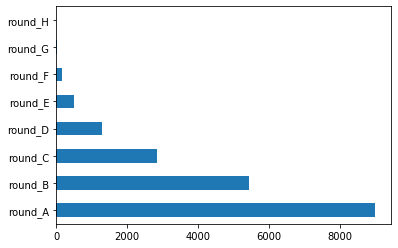

In [23]:
df.iloc[:,31:40].sum().plot(kind = 'barh');

In [24]:
def transform_data(df, how, output):
    
    if how == 'minmax':
        scaler = MinMaxScaler()
    elif how == 'standard':
        scaler = StandardScaler()
    else:
        scaler = PowerTransformer()
    
    if output == 'df':
        return pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
    else:
        return scaler.fit_transform(df)

Our data looks to be massively skewed.

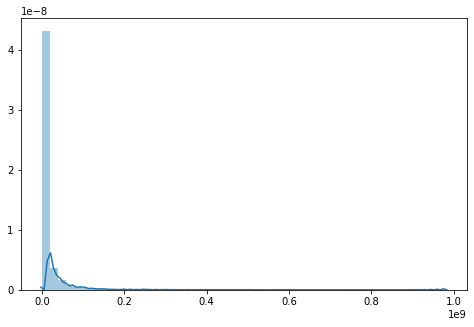

In [25]:
fig, ax = plt.subplots(figsize = (8,5))
sns.distplot(tot_funds[(tot_funds>0)&(tot_funds<10**9)]);

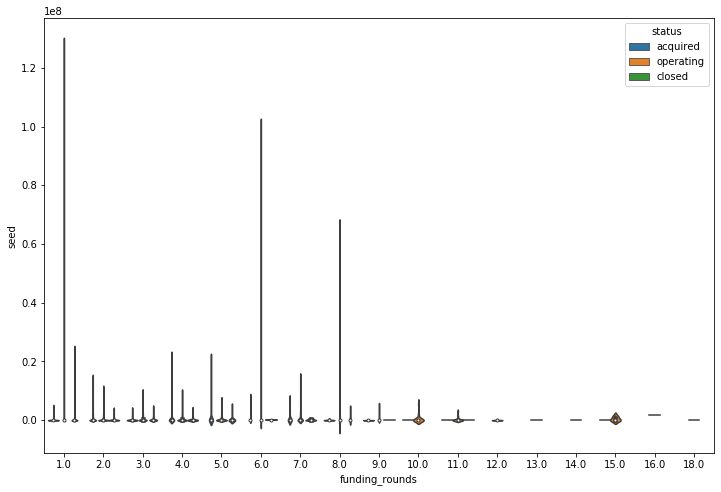

In [26]:
temp_df = df[df['seed']<10**9]
fig, ax = plt.subplots(figsize = (12,8))
sns.violinplot(x = 'funding_rounds', y = 'seed', hue = 'status', data = temp_df);
plt.show()

### Key findings:

- There is skew all over the dataset. We have some companies who've received enormous amounts of funding and others with almost nothing.
- We see countries in 

# Feature Engineering

#### There is much to do:

- We need to sort out categories that businesses fall into
- Names to manipulate
- Various times to turn into useful features
- We have many locations to minimise

#### Create dummies for popular categories

In [27]:
df.category_list = df.category_list.str.replace(' ','').str.replace('|', ' ')

In [28]:
df.category_list = df.category_list.fillna(' ')

In [29]:
df.category_list.head()

0             Entertainment Politics SocialMedia News 
1                                               Games 
2                                Publishing Education 
3     Electronics Guides Coffee Restaurants Music i...
4                         Tourism Entertainment Games 
Name: category_list, dtype: object

In [30]:
vectoriser = CountVectorizer()
sparse_cats = vectoriser.fit_transform(df.category_list)

In [31]:
cats_df = pd.DataFrame(sparse_cats.todense(), columns=vectoriser.get_feature_names())

Control for how many categories we want to maintain

In [32]:
num = 60
top_cats = list(cats_df.sum().sort_values(ascending = False)[0:num].index)

In [33]:
df = pd.concat([cats_df[top_cats], df], axis = 1)

In [34]:
df.drop(['category_list', 'market'], axis = 1, inplace = True)

#### Permalink and Name

In [35]:
df.permalink.apply(lambda x: x.split('/')[1] if x == str(x) else x).value_counts()

organization    49438
Name: permalink, dtype: int64

In [36]:
df.permalink.apply(lambda x: x.split('/')[2] if x == str(x) else x).value_counts()[0:10]

prysm                               2
treasure-valley-urology-services    2
northeast-wireless-networks         1
wegreek                             1
carevature-medical-north-america    1
corporateworld                      1
hunch                               1
boosted-boards                      1
spraingo                            1
idle-free-systems                   1
Name: permalink, dtype: int64

In [37]:
df.name.value_counts()[0:10]

Roost              4
Spire              4
Shift              3
Peach              3
Roadmap            3
Compass            3
Hubbub             3
Cue                3
TickTickTickets    2
Tiempo             2
Name: name, dtype: int64

Permalink and name carry slightly different information. But permalink doesn't appear to carry any unique information over the url so we will drop it.

In [38]:
df.drop('permalink', axis = 1, inplace = True)

Phil Knight of Nike spoke of how certain letters in a companies name and its length make it stickier. Lets create features for each.

In [39]:
df.name.head()

0              #waywire
1    &TV Communications
2     'Rock' Your Paper
3     (In)Touch Network
4    -R- Ranch and Mine
Name: name, dtype: object

Get name length.

In [40]:
df['name_len'] = df.name.apply(lambda x: len(re.sub("[^0-9A-Za-z]", "", x)) if str(x)==x else 0)

Sticky letters count.

In [41]:
df['sticky_letter_count'] = df.name.\
                                apply(lambda x: (len(re.sub("[^kKyYzZxX]", "", x))) if str(x)==x else 0).\
                                apply(lambda x: 1 if x>0 else 0)

Count the syllables.

In [42]:
def syllable_count(word):
    try:
        word = word.lower()
        count = 0
        vowels = "aeiouy"
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                count += 1
        if word.endswith("e"):
            count -= 1
        if count == 0:
            count += 1
        return count
    except:
        return 0

In [43]:
df['syllable_count'] = df.name.apply(lambda x: syllable_count(re.sub("[^A-Za-z]", "", x)) if str(x)==x else 0)

In [44]:
df.drop('name', axis = 1, inplace = True)

We're done with names, lets now look at url.

In [45]:
df.homepage_url.apply(lambda x: re.sub("[^A-Za-z.]", "", x).split('.')[-1] if str(x)==x else 'undefined').value_counts().head()

com          37722
undefined     3450
net            927
co             626
org            485
Name: homepage_url, dtype: int64

Given the quantity of .com's, its probably not worth creating a feature out of it. We don't need anything with URL so we can drop it.

In [46]:
df.drop('homepage_url', axis = 1, inplace = True)

#### Locations

In [47]:
num_cities = 20
city_list = list(df.city.value_counts()[:num_cities].index)

In [48]:
df.city = df.city.apply(lambda x: x.lower() if x in city_list else 'other_location')

In [49]:
df = pd.concat([pd.get_dummies(df.city, drop_first = True), df], axis = 1)

In [50]:
df.drop(['state_code', 'region', 'city', 'country_code'], axis = 1, inplace = True)

#### Date

In [51]:
df[['founded_month', 'founded_quarter', 'founded_year']].isnull().sum()

founded_month      10957
founded_quarter    10957
founded_year       10957
dtype: int64

In [52]:
df.drop(['founded_month', 'founded_quarter', 'founded_year'], axis = 1, inplace = True)

In [53]:
df['datetime'] = pd.to_datetime(df.founded_at, errors='coerce')

In [54]:
df['year_founded'] = df['datetime'].dt.year

In [55]:
df['month_founded'] = df['datetime'].dt.month

In [56]:
df['first_funding_year'] = pd.to_datetime(df['first_funding_at'], errors='coerce').dt.year
df['first_funding_month'] = pd.to_datetime(df['first_funding_at'], errors='coerce').dt.month

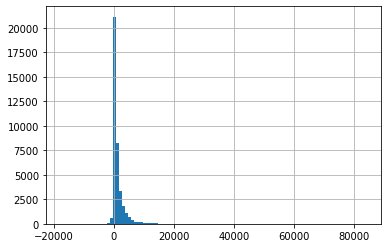

In [57]:
(pd.to_datetime(df['first_funding_at'], errors='coerce') - df['datetime']).dropna().dt.days.hist(bins = 100);

In [58]:
df['days_to_funded'] = (pd.to_datetime(df['first_funding_at'], errors='coerce') - df['datetime']).dt.days

In [59]:
df.drop(['founded_at', 'first_funding_at', 'last_funding_at', 'datetime'], axis = 1, inplace = True)

In [60]:
df['days_to_funded'] = df['days_to_funded'].apply(lambda x: np.nan if x<0 else x)

# Data imputation

In [61]:
df.isnull().sum().sort_values(ascending = False).head(20)

days_to_funded         13631
month_founded          10886
year_founded           10886
funding_total_usd       8532
status                  1315
first_funding_year        11
first_funding_month       11
convertible_note           1
private_equity             1
angel                      1
debt_financing             1
venture                    1
undisclosed                1
equity_crowdfunding        1
post_ipo_debt              1
seed                       1
funding_rounds             1
post_ipo_equity            1
grant                      1
secondary_market           1
dtype: int64

We will need to reverse days_to_funded to penalise the nulls we will be imputing.

In [62]:
df['days_to_funded'] = transform_data(df[['days_to_funded']], 'minmax', 'df')['days_to_funded'].fillna(1)

In [63]:
df['funding_total_usd'] = df['funding_total_usd'].fillna(0)

In [64]:
df.fillna(df.median(), inplace = True)

In [65]:
df.isnull().sum().sort_values().tail()

healthcare           0
hardware             0
entertainment        0
days_to_funded       0
status            1315
dtype: int64

In [66]:
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)

Lets now dummify month_founded, year_founded, first_funding_year, first_funding_month.

In [67]:
dates_cols = ['month_founded', 'year_founded', 'first_funding_year', 'first_funding_month']

df = pd.concat([df.drop(dates_cols, axis = 1),
                pd.get_dummies(df[dates_cols].astype(str))],
                axis = 1, sort = True)

# Modelling

In [68]:
df['status'].value_counts()

operating    41771
acquired      3692
closed        2603
Name: status, dtype: int64

In [69]:
print(round(df.status.value_counts(normalize = True),3).max())

0.869


In [70]:
X = df.drop('status', axis = 1)
        
y = df[['status']]

In [71]:
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [72]:
y = y.replace({'closed':0,
               'operating':1,
               'acquired': 2})

# Model 1 - undersampling

In [108]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y,
                                                    test_size = 0.1,
                                                    random_state = 1,
                                                    stratify = y,
                                                    shuffle = True)

In [109]:
rus = RandomUnderSampler(replacement = True)
X_train_u, y_train_u = rus.fit_resample(X_train, y_train)
X_train_u = pd.DataFrame(X_train_u, columns = Xs.columns)

In [90]:
pd.DataFrame(y_train_u)[0].value_counts().max()

2603

In [91]:
round(pd.DataFrame(y_train_u)[0].value_counts(normalize = True).max(),3)

0.333

#### Logistic Regression

In [111]:
param_grid_lr = {
    
    'C': np.logspace(-4,4,10),
    'penalty': ['l1', 'l2'],
    
}

grid_lr = GridSearchCV(LogisticRegression(random_state = 1, max_iter = 500, solver = 'saga'),
                       param_grid_lr,
                       cv = 5,
                       n_jobs = 2).fit(X_train_u, y_train_u)

In [112]:
grid_lr.best_score_

0.6211426372992209

In [118]:
print(grid_lr.best_params_)

{'C': 0.046415888336127774, 'penalty': 'l2'}


In [114]:
logreg = LogisticRegression(random_state = 1,
                   max_iter = 500,
                   C = grid_lr.best_params_['C'],
                   penalty = grid_lr.best_params_['penalty'],
                   solver = 'saga').fit(X_train, y_train)

In [115]:
coefs = pd.DataFrame({'coefs_closed':logreg.coef_[0],
                      'coefs_open':logreg.coef_[1],
                      'coefs_acquired':logreg.coef_[2],
                      'feature':X_train.columns})

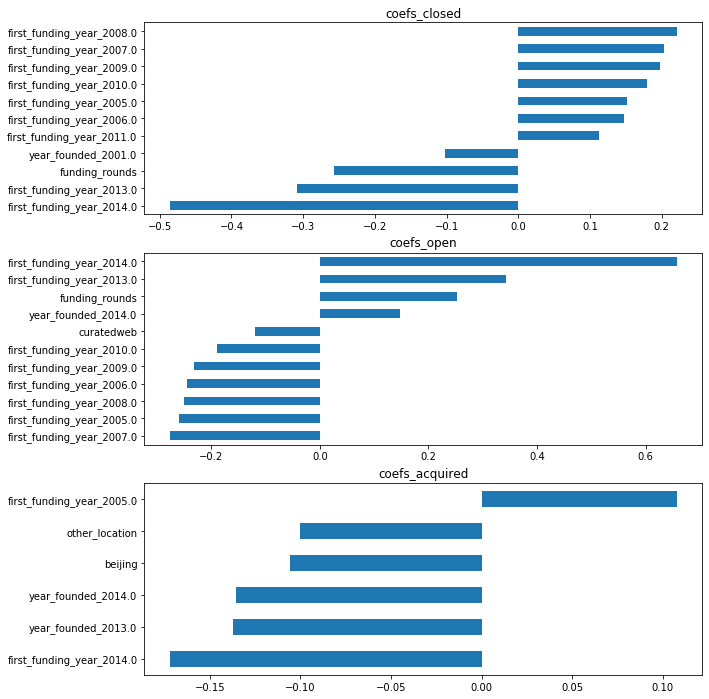

In [116]:
fig, ax = plt.subplots(nrows = 3, figsize = (10,12))

for i, v in enumerate(['coefs_closed', 'coefs_open', 'coefs_acquired']):
    coefs_to_plot = coefs[abs(coefs[v])>0.1].sort_values(v)
    coefs_to_plot.sort_values(v)[v].plot(kind = 'barh', ax = ax[i]);
    plt.sca(ax[i])
    plt.yticks(np.arange(len(coefs_to_plot['feature'].values)),
               (coefs_to_plot['feature'].values));
    plt.title(v)


In [119]:
cross_val_scores = cross_val_score(logreg, X_train_u, y_train_u, cv = 5)
print(cross_val_scores.mean())
print(cross_val_scores)
print(logreg.score(X_test, y_test))

0.6211426372992209
[0.6116643  0.6230441  0.63086771 0.60739687 0.63274021]
0.8668608279592261


In [120]:
def plot_confusion(cm):
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,  cmap = 'coolwarm')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.xticks([i-0.5 for i in range(1,4)], ['closed', 'open', 'acquired'])
    plt.yticks([i-0.5 for i in range(1,4)], ['closed', 'open', 'acquired'])

In [121]:
preds = logreg.predict(X_test)
cm_lr = confusion_matrix(y_test, preds)

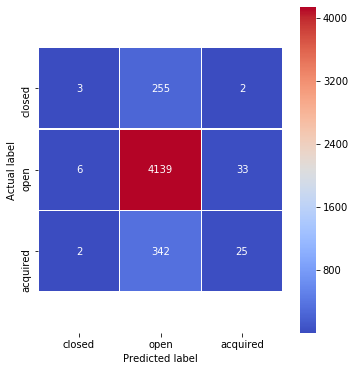

In [122]:
plot_confusion(cm_lr)

#### Random Forest 

In [123]:
param_grid = {
    
    'n_estimators':[150,300,400,500,600,700],
    'max_depth':[5,7,10,15,20,25,None],
    
}

In [124]:
grid = GridSearchCV(RandomForestClassifier(random_state = 1),
                    param_grid,
                    cv = 5,
                    n_jobs = 2).fit(X_train_u, y_train_u)

In [107]:
grid.best_score_

0.6718396156925541

In [108]:
print(grid.best_params_)

{'max_depth': None, 'n_estimators': 600}

In [97]:
clf = RandomForestClassifier(random_state = 1, max_depth =  None, n_estimators = 600).fit(X_train_u, y_train_u)

In [98]:
imps = pd.DataFrame({'importance':clf.feature_importances_,
                     'feature':X_train.columns})

In [99]:
imps.sort_values(by = 'importance').tail(10)

,importance,feature
104,0.016258,sticky_letter_count
82,0.023376,seed
81,0.025782,funding_rounds
300,0.027640,first_funding_year_2013.0
105,0.037571,syllable_count
301,0.039736,first_funding_year_2014.0
103,0.050902,name_len
83,0.053242,venture
106,0.053572,days_to_funded
80,0.074768,funding_total_usd


In [101]:
cross_val_scores = cross_val_score(clf, X_train_u, y_train_u, cv = 5)
print(cross_val_scores.mean())
print(cross_val_scores)

0.6868381104883907
[0.696      0.68054444 0.70216173 0.6797438  0.67574059]


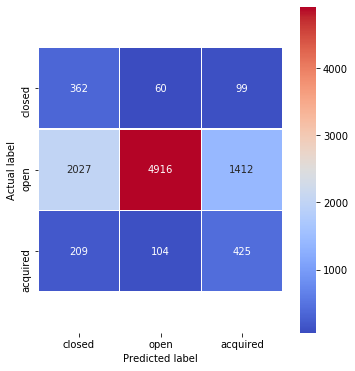

In [105]:
preds = clf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

In [106]:
clf.score(X_test, y_test)

0.5931974204285417

#### Analysis

Our models aren't particularly good. We score 69% on testing at best and 67% in cross validated training.

They both over predict closed and underpredict open.

Our strongest coefficient per class tends to be the year founded and the year of first funding.

Many of our newly constructed features were considered important by the random forest. The name can be a predictor of success it seems!

# Model 2 - SMOTE

In [74]:
from imblearn.over_sampling import SMOTE

In [75]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y,
                                                    test_size = 0.2,
                                                    random_state = 1,
                                                    stratify = y,
                                                    shuffle = True)

In [77]:
sm = SMOTE(random_state=0)

In [78]:
X_train_s, y_train_s = sm.fit_resample(X_train, y_train)

In [81]:
pd.DataFrame(y_train_s)[0].value_counts()

2    33416
1    33416
0    33416
Name: 0, dtype: int64

In [205]:
X_train_s.shape

(100248, 314)

In [207]:
param_grid = {
    
    'n_estimators':[150,300,450,600],
    'max_depth':[10,15,25,None],
    
}

grid = GridSearchCV(RandomForestClassifier(random_state = 1),
                    param_grid,
                    cv = 5,
                    n_jobs = 2).fit(X_train_s, y_train_s)

In [208]:
print(grid.best_score_)

print(grid.best_params_)

0.9444285371164834
{'max_depth': None, 'n_estimators': 600}


In [209]:
final_rf = RandomForestClassifier(random_state = 1, n_estimators = 600).fit(X_train_s, y_train_s)
print(final_rf.score(X_test, y_test))

0.8646765134179322


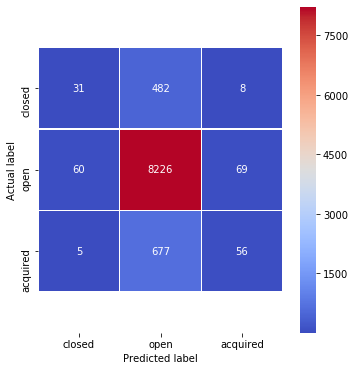

In [210]:
preds = final_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

In [218]:
print('But our baseline is {}.'.format(round(y_test['status'].value_counts(normalize = True).max(),3)))

But our baseline is 0.869.


# Changing the challenge

The majority of the companies we've been dealing with have been still operating. Let's strip these away and just try to predict whether they close or get acquired.

In [131]:
df_new = df[(df['status']=='acquired')|(df['status']=='closed')]

In [137]:
X = df_new.drop('status', axis = 1)
        
y = df_new[['status']]

In [138]:
scaler = StandardScaler()
Xs = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [139]:
y = y.replace({'closed':0,
               'acquired': 1})

In [173]:
y.mean()

status    0.586497
dtype: float64

In [140]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y,
                                                    test_size = 0.2,
                                                    random_state = 1,
                                                    stratify = y,
                                                    shuffle = True)

In [166]:
param_grid = {
    
    'n_estimators':[150,225,300,375,450,600],
    'max_depth':[5,7,10,12,15,25,None],
    'min_samples_leaf': [1,2,5],
    'ccp_alpha': [0.0001, 0.015, 0.02, 0.03]
    
}

grid = GridSearchCV(RandomForestClassifier(random_state = 1),
                    param_grid,
                    cv = 5,
                    n_jobs = 2).fit(X_train, y_train)

In [167]:
print(grid.best_score_)

print(grid.best_params_)

0.7374899512933276
{'ccp_alpha': 0.0001, 'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 225}


In [168]:
rf_new = RandomForestClassifier(random_state = 1,
                                n_estimators = 300,
                                max_depth = 25
                               ).fit(X_train, y_train)

print(rf_new.score(X_test, y_test))

0.7458300238284352


In [169]:
def plot_confusion(cm):
    plt.figure(figsize=(6,6))
    ax = sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True,  cmap = 'coolwarm')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    plt.xticks([i-0.5 for i in range(1,3)], ['closed', 'acquired'])
    plt.yticks([i-0.5 for i in range(1,3)], ['closed', 'acquired'])

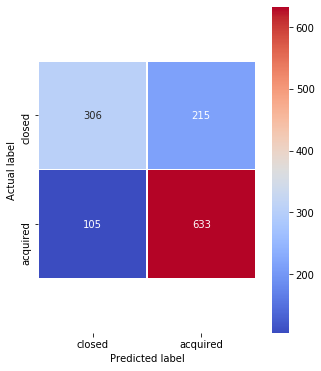

In [170]:
preds = rf_new.predict(X_test)
cm_rf = confusion_matrix(y_test, preds)
plot_confusion(cm_rf)

In [171]:
imps_new = pd.DataFrame({'importance':rf_new.feature_importances_,
                     'feature':X_train.columns})

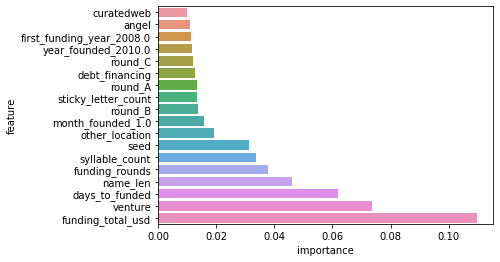

In [172]:
imps_to_plot = imps_new[imps_new['importance']>0.01].sort_values(by = 'importance')

sns.barplot(x = imps_to_plot['importance'],
            y = imps_to_plot['feature']);

Now we see quite different coefficients. Lets check logistic regression.

In [174]:
param_grid_lr = {
    
    'C': np.logspace(-4,4,25),
    'penalty': ['l1', 'l2'],
    
}

grid_lr_new = GridSearchCV(LogisticRegression(random_state = 1, max_iter = 500, solver = 'saga'),
                       param_grid_lr,
                       cv = 5,
                       n_jobs = 2).fit(X_train, y_train)

In [175]:
print(grid_lr_new.best_score_)

print(grid_lr_new.best_params_)

0.714060110969247
{'C': 0.046415888336127774, 'penalty': 'l1'}


In [176]:
logreg_new = LogisticRegression(random_state = 1,
                   max_iter = 500,
                   C = grid_lr_new.best_params_['C'],
                   penalty = grid_lr_new.best_params_['penalty'],
                   solver = 'saga').fit(X_train, y_train)

In [185]:
coefs_new = pd.DataFrame({'coef': logreg_new.coef_[0],
                          'abs_coef': abs(logreg_new.coef_[0]),
                          'feature': X_train.columns})

In [187]:
coefs_new.sort_values('abs_coef', ascending = False).head(10)

,coef,abs_coef,feature
10,-0.243371,0.243371,other_location
95,0.203895,0.203895,round_A
107,0.170823,0.170823,month_founded_1.0
81,0.169337,0.169337,funding_rounds
34,0.168138,0.168138,analytics
97,0.161328,0.161328,round_C
295,-0.156303,0.156303,first_funding_year_2008.0
301,0.156140,0.156140,first_funding_year_2014.0
26,0.153102,0.153102,enterprisesoftware
83,0.146870,0.146870,venture


We can now do much better, our random forest hit almost 75% accuracy, which is much better than the ~50% benchline for this model.